## OCR

In [2]:
import string
from PIL import Image, ImageDraw, ImageFont
import numpy as np
from numpy.fft import fft2, ifft2

Funkcja do tworzenia obrazu z tekstem.
Przyjmuje tekst z określoną wielkością fonta, ostateczny rozmiar obrazu jest tak dopasowywany, aby tekst się zmieścił.
Przy testowaniu OCR zakładam, że tekst ma font_size równy przynajmiej 20.
W testach używam dwóch czcionek szeryfowych (Times New Roman i Courier) i dwóch czcionek bezszeryfowych (Arial i Open-sans).
Czcionka Courier jest do tego czcionką o stałej szerokości znaku.
Obraz ma także padding na tyle duży, żeby tekst dało się potem obrócić bez straty informacji i bez zmieniania wymiarów obrazu.


In [3]:
def draw_multiline_text(text, size=(800, 600), font_size=40, font='arial', show=False):

    def fit_horizontal():
        return upper_x > padding_x and lower_x < size[0] - padding_x

    def fit_vertical():
        return upper_y > padding_y and lower_y < size[1] - padding_y

    padding_x = size[0] // 7
    padding_y = size[1] // 7
    center = (size[0] // 2, size[1] // 2)
    img = Image.new("RGB", size, (255, 255, 255))
    d = ImageDraw.Draw(img)

    fnt = ImageFont.truetype(f"fonts/{font}.ttf", font_size)
    upper_x, upper_y, lower_x, lower_y = d.multiline_textbbox(center, text, anchor='mm', font=fnt)
    if not fit_horizontal():
        return draw_multiline_text(text, size = (size[0] + 100, size[1]),
                                   font_size=font_size, font=font, show=show)
    if not fit_vertical():
        return draw_multiline_text(text, size = (size[0], size[1] + 100),
                                   font_size=font_size, font=font, show=show)

    d.multiline_text(center, text, anchor='mm', font=fnt, fill=(0, 0, 0))
    if show:
        display(img)
    return img, font_size

Zbiór znaków do rozpoznawania do liter małych i dużych, cyfr i kilku innych znaków.
Czasami przy porównywaniu wyników nie będę w tym zbiorze uwzględniał kropki i przecinka, gdyż
te znaki są wykrywane w wielu miejscach na obrazie i znacząco zmieniają wynik.

In [238]:
characters = string.ascii_uppercase + string.ascii_lowercase + string.digits + ".,?!"

Znaki któych nie uwzględniam zastępuje spacjami.

In [239]:
def filter_text(text):
    return "".join(list(map(lambda x: x if x in characters or x == '\n' else " ", text)))

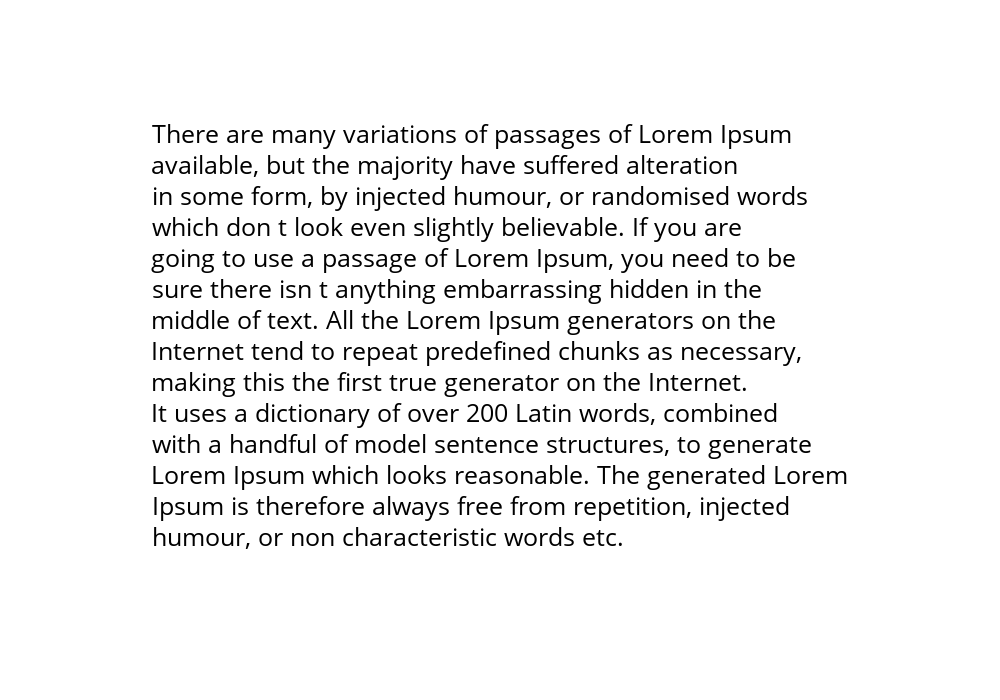

In [240]:
txt = '''There are many variations of passages of Lorem Ipsum
available, but the majority have suffered alteration
in some form, by injected humour, or randomised words
which don't look even slightly believable. If you are
going to use a passage of Lorem Ipsum, you need to be
sure there isn't anything embarrassing hidden in the
middle of text. All the Lorem Ipsum generators on the
Internet tend to repeat predefined chunks as necessary,
making this the first true generator on the Internet.
It uses a dictionary of over 200 Latin words, combined
with a handful of model sentence structures, to generate
Lorem Ipsum which looks reasonable. The generated Lorem
Ipsum is therefore always free from repetition, injected
humour, or non-characteristic words etc.
'''
txt = filter_text(txt)
out, f_size = draw_multiline_text(txt, size= (600, 400), font='open-sans', font_size=25, show=True)

Funkcja do obracania zdjęcia

In [196]:
def rotate_image(img, angle):
    return img.rotate(angle, fillcolor=(255, 255, 255), resample=Image.BICUBIC)

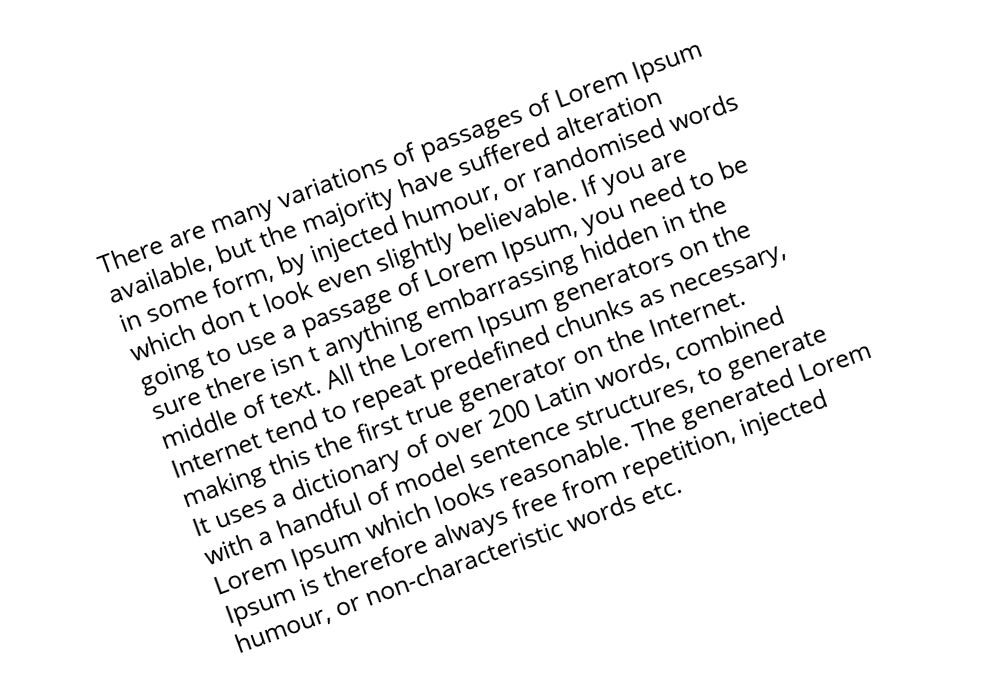

In [39]:
display(rotate_image(out, 20))

Rysowanie pojedynczych liter.
Są rysowane dla konkretnej wielkości czcionki. Używam ich potem jako wzorców przy OCR.

In [241]:
def remove_black_padding(img):
    matrix = np.array(img)
    if np.alltrue(np.argmax(matrix, axis=1) > 0):
        matrix[:, :np.argmax(matrix[0])] = 255
    return Image.fromarray(matrix)

def draw_single_character(char, font_size, font='arial', show=False):
    img = Image.new("L", (200, 200), 255)
    d = ImageDraw.Draw(img)
    fnt = ImageFont.truetype(f"fonts/{font}.ttf", font_size)
    w = d.textbbox((0, 0), char, font=fnt)
    d.text((0, 0), char, font=fnt, fill=0)
    img = img.crop(w)
    if char in characters:
        img = remove_black_padding(img)
    if show:
        display(img)
    return img

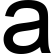

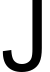

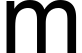

In [242]:
for letter in ['a', 'J', '!', 'm']:
    draw_single_character(letter, 99, font='arial', show=True)

In [243]:
def get_all_character_images(font, fontsize): # Rysowanie wszystkich znaków z użyciem powyższej funkcji
    return list(map(lambda x: draw_single_character(x, fontsize, font), characters))

def img_to_matrix(img):
    img = img.convert('L')
    return np.array(img, dtype=float)

def matrix_to_image(matrix):
    return Image.fromarray(matrix).convert('L')

def invert_colors(matrix):
    return 255 - matrix

def normalize(matrix):
    """
    Sprowadzenie wartości z macierzy do wartości z przedziału 0-255
    na przykład po zastosowaniu SVD
    """
    return 255 * (matrix / np.max(matrix))


def threshold(matrix, k=150):
    """Zamiana wartości macierzy na binarne"""
    black = matrix < k
    white = matrix >= k
    matrix[black] = 0
    matrix[white] = 255
    return matrix


Redukcja szumu.
Jako, że obrazy są generowane a nie skanowane nie występuje na nich szum. Użycie SVD ma więc efekt odwrotny do zamierzonego.
Funkcja ta może być użyta, aby obraz z tekstem wyglądał bardziej naturalnie

In [44]:
def reduce_noise(img, k = 200):
    matrix = img_to_matrix(img)
    u, s, v = np.linalg.svd(matrix)
    mat = u[:, :k] @ np.diag(s[:k]) @ v[:k, :]
    return matrix_to_image(normalize(mat)).convert('L')

### Wyrównywanie tekstu

Algorytm wyrównywania tekstu polega na obracaniu obrazu i zliczaniu poziomych białych linii. Jeśli tekst jest wyrównany to takich linii będzie najwięcej.
Wcześniej macierz jest zamieniana na binarną. Zakładam, że obrazy są obrócone o kąt który jest liczbą całkowitą. ALgorytm testuje więc za każdym razem 180 możliwości poprawy.

In [12]:
def count_horizontal_lines(img):
    """
    Zliczanie poziomych linii,
    uwzględniam jedynie białe linie, które znajdują się pomiędzy liniami, które zawierają czarne piksele
    """
    matrix = invert_colors(threshold(img_to_matrix(img)))
    matrix = np.sum(matrix, axis=1)
    matrix[matrix > 0] = 1
    return matrix.shape[0] - np.count_nonzero(matrix) - np.argmax(matrix) - np.argmax(matrix[::-1])

def count_something(img):
    """Liczenie pikseli z prawej strony obrazy"""
    matrix = invert_colors(threshold(img_to_matrix(img)))
    rows = np.argmax(matrix[:, ::-1], axis=1)
    cols = np.argmax(matrix[::-1, :], axis=0)
    return 3*np.sum(rows) + np.sum(cols)

def upside_down(img):
    return count_something(img) < count_something(rotate_image(img, 180))

def correct_angle(img):
    scores = np.zeros(180)
    for i in range(180):
        rotated = rotate_image(img, i)
        scores[i] = count_horizontal_lines(rotated)

    best_angle = np.argmax(scores)
    img = rotate_image(img, best_angle)
    if upside_down(img):
        return rotate_image(img, 180)
    return img


Widać jednak, że istnieją dwa ustawienia w których ilość poziomych linii jest taka sama. Jest to w przypadku, gdy tekst jest wyrównany albo obrócony o 180 stopni.(Jak na zdjęciu poniżej)

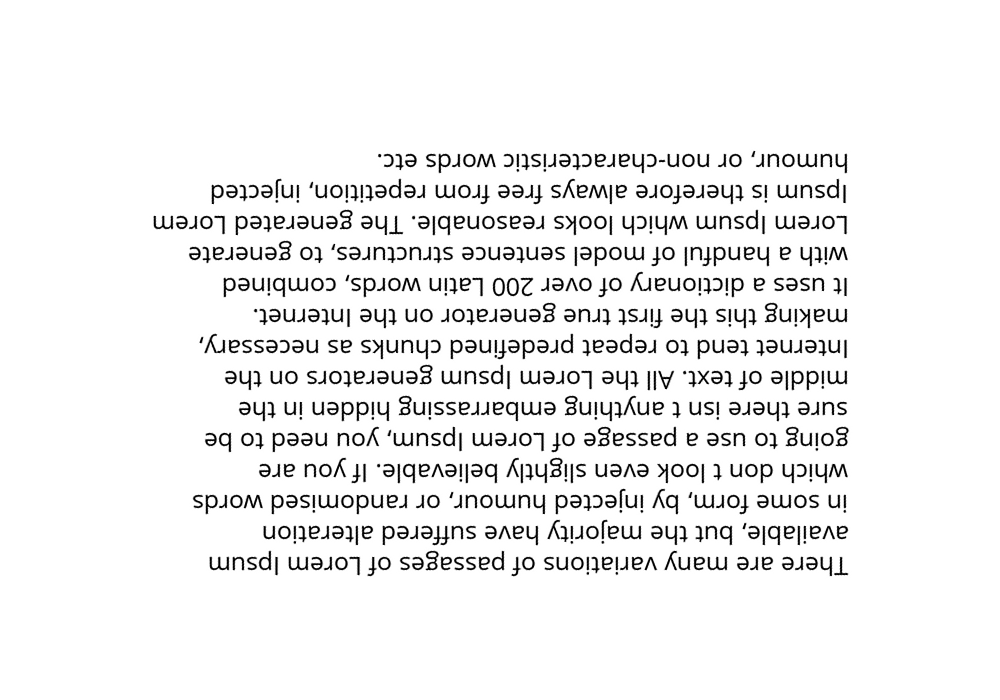

In [46]:
display(correct_angle(rotate_image(out, 20)))

Można zauważyć, że jeżeli obraz reprezentuje jakiś faktyczny tekst to zazwyczaj po prawej stronie jest więcej niezajmowanej przestrzeni, gdyż tekst jest wyrównany do lewej strony. Zliczam więc ilość białych pikseli do wystąpienia pierwszego czarnego piksela dla każdej linii zaczynając od prawej strony obrazy.

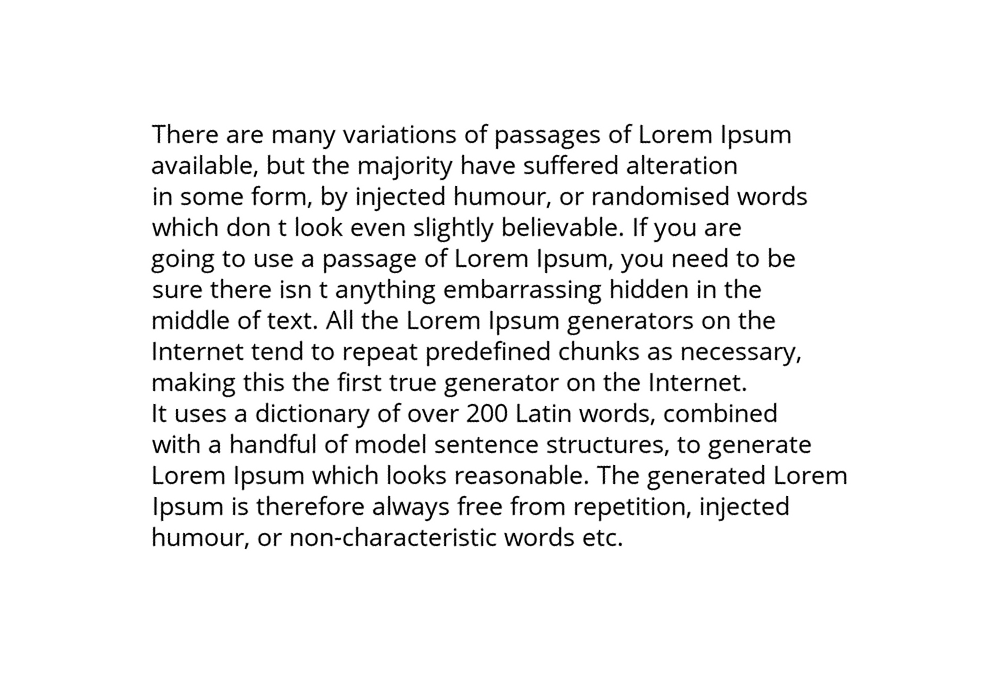

In [50]:
display(correct_angle(rotate_image(out, 20)))

Po zastosowaniu takiej korekty dla większości przypadków jest już znajdowane poprawne ustawienie obrazu.
Algorytm ten ma jednak wiele wad, obraca jedynie o kąty będące liczbą całkowitą i musi sprawdzić 180 przypadków, przez co nie jest specjalnie szybki.
Kwestia stwierdzania czy obraz jest obrócony o 180 stopnie można by rozwiązać szukając na obrazie liter normalnych i obróconych i decydować na podstawie tego których liter wystąpiło więcej.

## Optical character recognition

W przeciwieństwie do zad1 i szukania literki e tutaj nigdy nie mamy pewności czy dana litera występuje w podanym na zdjęciu tekście, dlatego przy wykrywaniu litery na obrazie jako maksymalną korelację nie przyjmuje maksymalnej wartości się pojawiła, lecz korelację szukanego wzorca samego ze sobą, czyli kwadrat normy Frobeniusa danej macierzy.

In [13]:
def convolve_images(pattern, image):
    """Funkcja licząca splot dwóch obrazów"""
    s = (max(pattern.shape[0], image.shape[0]), max(pattern.shape[1], image.shape[1]))
    return np.abs(ifft2(fft2(pattern[::-1, ::-1], s=s) * fft2(image, s=s)))


def find_occurrences(pattern, image, eps=0.05):
    """
    Funkcja zwraca wszystkie potencjalne wystąpienia patternu na zdjęciu.
    Parametr eps określa jak przedział korelacji uznawać za wystąpienie danej liczby.
    Jego wartość jest dobierana empirycznie i jej 'dobra' wartość zmienia się w zależności od rodzaju i wielkości czcionki,
    a także tego, czy rozpoznawany obraz był wcześniej obrócony, przez co wygląd liter mógł ulec zmianom
    """
    convolution = convolve_images(pattern, image)
    max_correlation = np.sum(pattern * pattern)
    return list(zip(*np.where(np.abs(convolution - max_correlation) < eps * max_correlation)))

Największym problemem przy implementacji OCR było wykrywanie liter, które często błędnie wykrywały się wewnątrz innych liter, np. n wewnątrz h albo c wewnątrz o. Znak kropki i przecinka wykrywał się w praktycznie w każdym miejscu w tekście. Są też charakterystyczne znaki, które praktycznie zawsze są poprawnie rozpoznawane. Można w takim razie przeszukiwanie tekstu zacząć od znajdywania tych charakterystycznych liter i dopiero potem przechodzić do tych trudniejszych. Maleje wtedy szansa niepoprawnej klasyfikacji. Na przkład jeśli n wykrywa się na literze h, a h już nie wykrywa się na literze n to najpierw powinno szukać się litery h, a później litery n. Główna trudność zadania sprowadza się wtedy do znalezienia odpowiedniej kolejności.

Można zbudować skierowany graf zależności, gdzie wierzchołkami są znaki, a krawędź z v do u istnieje wtedy, gdy litera u jest niepoprawnie wykrywana w miejscu litery v. Taka krawędź mówi nam, że w optymalnym porządku litera v powinna poprzedzać literę u. Poniższa funkcja buduje właśnie taki graf.

In [252]:
import networkx as nx

def prepare_images(images):
    """
    Zamiana obrazów na macierze z jednoczesnym odwróceniem kolorów i zamianą na macierz binarną.
    """
    return list(
        map(lambda x: threshold(x, 220),
        map(invert_colors,
        map(img_to_matrix, images)))
    )

def create_graph(font, font_size, chars, eps=0.05):
    """
    Funkcja buduje graf dla danej czcionki i rozmiaru. Lista chars zawiera listę macierzy reprezentujących pojedyncze litery.
    Lista images jest praktycznie tym samym, ale obraz litery posiada większy padding. Krawędź z v do u powstanie, jeśli
    char[u] zostanie wykryte gdzieś w images[v].
    """
    images = [draw_multiline_text(c, size=(font_size*2, font_size*2), font=font, font_size=font_size)[0] for c in characters]
    images = prepare_images(images)
    graph = nx.DiGraph()
    graph.add_nodes_from(range(len(images)))
    for i, pattern in enumerate(chars):
        for j, image in enumerate(images):
            if i != j and find_occurrences(pattern, image, eps):
                graph.add_edge(j, i)
    return graph

In [244]:
%%time
g = create_graph('open-sans', 30, prepare_images(get_all_character_images('open-sans', 30)))

CPU times: total: 1.69 s
Wall time: 1.69 s


In [245]:
print(g)
try:
    nx.find_cycle(g)
    print("Graph has cycles")
except:
    print("No cycles found")
print(nx.is_strongly_connected(g))

DiGraph with 66 nodes and 131 edges
No cycles found
False


W tym przypadku otrzymany graf jest acykliczny skierowany, więc logiczne było by po prostu sortowanie topologiczne.
Jednak w tym przypadku dobrana wartość epsilon wynosiła 0.05 więc dość mało. W przypadku analizy obrazów obróconych dużo lepszą wartością jest 0.1

In [246]:
%%time
g = create_graph('open-sans', 30, prepare_images(get_all_character_images('open-sans', 30)), eps=0.1)

CPU times: total: 1.75 s
Wall time: 2.02 s


In [247]:
print(g)
try:
    nx.find_cycle(g)
    print("Graph has cycles")
except:
    print("No cycles found")
print(nx.is_strongly_connected(g))

DiGraph with 66 nodes and 211 edges
Graph has cycles
False


Dla takiej wartości w grafie pojawiają się już cykle. Próba posortowania topologicznego takiego grafu zwróciłaby wyjątek, więc ogólniejszą nie rzucającą wyjątkami metodą jest posortowanie topologiczne silnie spójnych składowych tego grafu i wzięcie dowolnej kolejności wierzchołków w obrębie jednej składowej.

In [248]:
components = nx.strongly_connected_components(g)
for component in components:
    if len(component) > 1:
        for vertex in component:
            print(characters[vertex], end=" ")
        print()

I l 
q d 


Występują tylko dwie spójne składowe o wielkości większej niż jeden i obie zawierają po dwa wierzchołki

In [249]:
def almost_topological_order(graph):
    dag = nx.condensation(graph)
    order = [member for c in nx.topological_sort(dag)
             for member in dag.nodes.data()[c]['members']]
    return np.array(order)

Można także zauważyć, że wierzchołki, które są na końcu, nie mają żadnych krawędzi wychodzących, ale mogą mieć dużo krawędzi wchodzących. Jeśli by teraz 'ważność' wierzchołka zdefiniować patrząc na ilość wchodzących krawędzi, to można powiedzieć, że wierzchołek jest tym ważniejszy im więcej ważnych wierzchołków ma do niego krawędź. Przypomina to poniekąd główną ideę algorytmu Pagerank, więc możliwym dobrym porządkiem wierzchołków jest ich kolejność uzyskana na podstawie wag uzyskanych po pageranku posortowana od najmniejszej.

In [250]:
def pagerank_order(graph):
    rank = nx.pagerank(graph).values()
    return np.argsort(np.array(list(rank)))

Dla porównania kolejności uzyskane po pageranku i użyciu algorytmu z silnie spójnymi składowymi.

In [251]:
print(f"Almost topological: {list(map(lambda x: characters[x], almost_topological_order(g)))}\n")
print(f"Pagerank: {list(map(lambda x: characters[x], pagerank_order(g)))}\n")

Almost topological: ['A', 'B', 'D', 'F', 'G', 'H', 'J', 'K', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'q', 'd', 'e', 'f', 'g', 'h', 'j', 'k', 'm', 'o', 'p', 's', 't', 'u', 'w', 'x', 'y', 'z', '0', '2', '3', '4', '5', '6', '7', '8', '9', '?', 'E', 'O', 'n', 'c', 'v', '1', 'L', 'C', 'r', 'I', 'l', ',', 'i', '!', '.']

Pagerank: ['A', 'f', '?', 'h', 'j', 'k', 'm', 'o', 'p', 's', 't', 'u', 'e', 'w', 'y', 'z', '0', '2', '3', '4', '5', '6', '7', '8', '9', 'x', 'b', 'g', 'F', 'N', 'J', 'a', 'P', 'Q', 'D', 'G', 'R', 'S', 'M', 'K', 'U', 'V', 'B', 'W', 'X', 'Y', 'Z', 'H', 'T', 'E', 'n', 'O', '1', 'L', 'v', 'd', 'q', 'C', 'c', 'r', 'l', 'I', 'i', '!', ',', '.']



## Końcowy algorytm
Na początku tworzony jest graf zależności i na jego podstawie ustalana jest odpowiednia kolejność wierzchołków (wybranym algorytmem).
Potem znajduje kolejne linie, szukając odpowiednio szerokich dla danej wielkości fonta poziomych linii bez żadnego tekstu.
Następnie przechodzę po literach w odpowiedniej kolejności i znajduje ich wystąpienia na obrazie. Skoro podzieliłem już tekst na linie to po współrzędnych wystąpienia danej litery, mogę stwierdzić, do której trafia do linii. Wtedy jedną literę mogę reprezentować jako pojedynczy przedział. Jeśli nowy przedział przecina się z jakimś już istniejącym przedziałem, to literę odrzucam, a jeśli nie, to ją akceptuję. Do obsługi zapytań o przecięcia przedziałów i dodawanie nowych przedziałów używam struktury drzewa przedziałów (IntervalTree).

In [322]:
from bisect import bisect_left
from intervaltree import IntervalTree, Interval

def split_lines(matrix):
    matrix = np.sum(matrix, axis=1)
    matrix[matrix > 0] = 1
    lines = [np.argmax(matrix) - 1]
    i = lines[-1] + 1
    while i < matrix.shape[0]:
        if matrix[i] == 0:
            lines.append(i)
            while i < matrix.shape[0] and matrix[i] == 0:
                i += 1
        i += 1
    return lines[:-1]

def remove_empty(lines, font_size):
    min_height = font_size // 3
    new_lines = [lines[0]]
    for x in lines[1:]:
        if x - new_lines[-1] > min_height:
            new_lines.append(x)
    return new_lines


def ocr(image, font, font_size, eps=0.05, order_func=almost_topological_order, order=None, rotate=False, noise=False):
    if rotate:
        image = correct_angle(image)
    if noise:
        image = reduce_noise(image)
    chars = get_all_character_images(font, font_size)
    char_arrays = prepare_images(chars)
    matrix = prepare_images([image])[0]

    if order is None:
        graph = create_graph(font, font_size, char_arrays, eps)
        order = order_func(graph)

    lines = remove_empty(split_lines(matrix), font_size)
    n = len(lines)
    intervals = [IntervalTree() for _ in range(n)]

    for c in order:
        for i, j in find_occurrences(char_arrays[c], matrix, eps):
            inter = bisect_left(lines, i) - 1
            left, right = j - char_arrays[c].shape[1] + 1, j - 1
            if left >= right:
                left, right = j - 2, j - 1
            new_inter = Interval(left, right, data=c)
            if intervals[inter].overlaps(new_inter):
                continue
            intervals[inter].add(new_inter)

    space = img_to_matrix(draw_single_character(' ', font_size, font)).shape[1] # szerokość spacji
    sorted_lines = [sorted(line.items()) for line in intervals]
    sorted_lines = list(filter(len, sorted_lines))

    leftmost = min(line[0].begin for line in sorted_lines)
    output = ""
    for line in sorted_lines:
        last_x = leftmost
        for left, right, char in line:
            if left - last_x >= space:
                output += " "*((left - last_x) // space)
            output += characters[char]
            last_x = right
        output += '\n'

    return output

## Testowanie

### Metryki do oceny jakości

Przy ocenie jakości odczytanego tekstu, poza licznikiem wystąpień każdej litery ważna jest także ich wzajemna kolejność dlatego używam do tego odległości Levenshtein'a


In [254]:
import Levenshtein

def edit_dist1(s1, s2):
    return 1 - Levenshtein.distance(s1, s2) / max(len(s1), len(s2))

def edit_dist2(s1, s2):
    """
    Porównanie dwóch tekstów, nie licząc znaku kropki i przecinka, a także znaków białych.
    """
    s1 = list(filter(lambda x: x in characters and not x in '.,', list(s1)))
    s2 = list(filter(lambda x: x in characters and x not in '.,', list(s2)))
    return edit_dist1(s1, s2)

In [255]:
def compare_texts(s1, s2):
    """
    Wypisuje odległość dwóch napisów według powyższych metryk.
    A także zlicza  ilość poprawnie rozpoznanych liter i wszystkich liter.
    """
    print(edit_dist1(s1, s2))
    print(edit_dist2(s1, s2))

In [314]:
def test(text, font, font_size, angle=0, **kwargs):
    img, font_size = draw_multiline_text(text, size= (600, 400), font=font, font_size=font_size)
    if angle:
        img = rotate_image(img, angle)
    res = ocr(img, font, font_size, **kwargs)
    print(res)
    compare_texts(res, text)
    res = ocr(img, font, f_size, order_func=pagerank_order, **kwargs)
    compare_texts(res, text)

Pierwsze testy obejmują rozpoznawanie tekstów na obrazach, które są już poprawnie zorientowane.

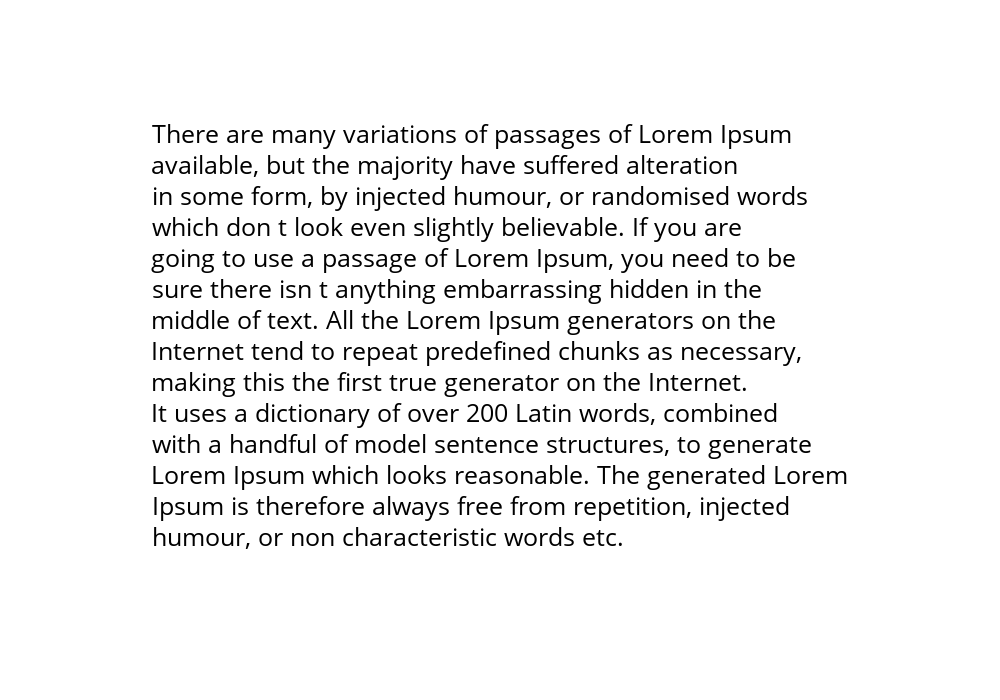

In [257]:
out, f_size = draw_multiline_text(txt, size= (600, 400), font='open-sans', font_size=25, show=True)

#### Open-sans

In [258]:
test(txt, 'open-sans', f_size)

There are many variations of passages of Lorem Ipsum
available, but the majority have suffered alteration
in some form, by injected humour, or randomised words
which don t look even slightly believable. If you are
going to use a passage of Lorem Ipsum, you need to be
sure there isn t anything embarrassing hidden in the
middle of text. All the Lorem Ipsum generators on the
Internet tend to repeat predefined chunks as necessary,
making this the first true generator on the Internet.
It uses a dictionary of over 200 Latin words, combined
with a handful of model sentence structures, to generate
Lorem Ipsum which looks reasonable. The generated Lorem
Ipsum is therefore always free from repetition, injected
humour, or non characteristic words etc.

1.0
1.0
1.0
1.0


#### Arial

In [259]:
test(txt, 'arial', f_size)

There are many variations of passages of Lorem Ipsum
avaiIabIe, but the majority have suffered aIteration
in some form, by injected humour, or randomised words
which don t Iook even sIightIy beIievabIe. If you are
going to use a passage of Lorem Ipsum, you need to be
sure there isn t anything embarrassing hidden in the
middIe of text. AII the Lorem Ipsum generators on the
Internet tend to repeat predefined chunks as necessary,
making this the first true generator on the Internet.
It uses a dictionary of over 200 Latin words, combined
with a handfuI of modeI sentence structures, to generate
Lorem Ipsum which Iooks reasonabIe. The generated Lorem
Ipsum is therefore aIways free from repetition, injected
humour. or non characteristic words etc.
            ,

0.9594771241830066
0.9738988580750407
0.9594771241830066
0.9738988580750407


#### Times

In [260]:
test(txt, 'times', f_size)

There are many variations ofpassages ofLorem Ipsum
available, but the ma.ority have suftered alteration
in some f .rm, by injected humour, or randomised words
which don t look even sli..htlv believable. Ifvou are
going to use,a passage ofg,orem Ipsum,,you yeed to be
sure there isn t,anvthin.. embarrassin.. hidden in the
middle oftext. Alythe,gorem Ipsum,generators,on,the
Internet tend to repeat predef,ned chunks as necessary,
makin.. this the f.rst true ..enerator on the Internet.
It,uses a dictionarv ofover 200 Latin,words  combined
with a handf,.l,ofmodel sentence structures, to ,,enerate
Lorem,Ipsum which looks reasonable. The generated Lorem
Ipsum is theref .re always f ee f om repetition, injected
humour, or non characteristic words etc.

0.9309428950863214
0.9624796084828712
0.9270557029177718
0.9608482871125612


#### Courier

In [187]:
test(txt, 'cour', f_size)

There are man  variations of  assa es of Lorem I sum
available, but the-majority have sgffered-alterapion
in some form, by injected humour, or randomised words
which don t look even sli htl  believable. If  ou are
going to use-a passage ofgLorem Ipsum, you need to be
sure there isn t an thin  embarrassin  hidden in the
middle of text. Allythe gorem I sum- enerators-on the
Internet tend to repeat predefined cgunks as necessary,
makin  this the first true  enerator on the Internet.
It uses a-dictionary of oveg 200 Latin words, combined
with a handful of model sentence structures, to generate
Lorem I sum which looks reasonable. The  enerated Lorem
Ipsum ip therefore-always free from repegition, injected
humour, or non-characteristic words etc.

0.9573901464713716
0.9495114006514658
0.9573901464713716
0.9478827361563518


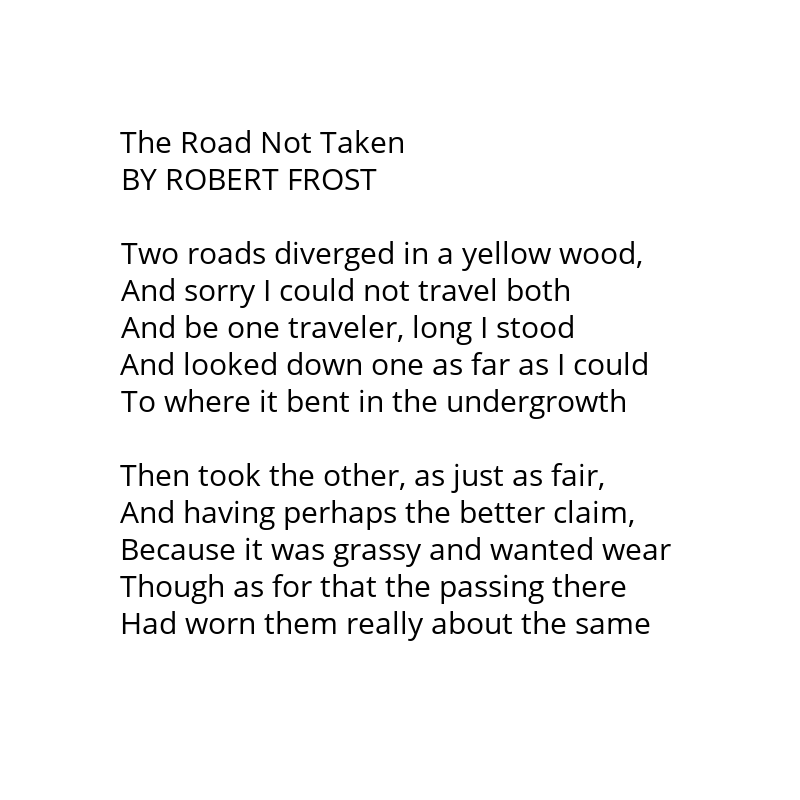

In [267]:
txt = '''The Road Not Taken
BY ROBERT FROST

Two roads diverged in a yellow wood,
And sorry I could not travel both
And be one traveler, long I stood
And looked down one as far as I could
To where it bent in the undergrowth;

Then took the other, as just as fair,
And having perhaps the better claim,
Because it was grassy and wanted wear;
Though as for that the passing there
Had worn them really about the same
'''
txt = filter_text(txt)
_, f_size = draw_multiline_text(txt, size= (600, 400), font='open-sans', font_size=30, show=True)

#### Open-sans

In [268]:
test(txt, 'open-sans', f_size)

The Road Not Taken
BY ROBERT FROST
Two roads diverged in a yellow wood,
And sorry I could not travel both
And be one traveler, long I stood
And looked down one as far as I could
To where it bent in the undergrowth
Then took the other, as just as fair,
And having perhaps the better claim,
Because it was grassy and wanted wear
Though as for that the passing there
Had worn them really about the same

0.9900990099009901
1.0
0.9900990099009901
1.0


#### Arial

In [269]:
test(txt, 'arial', f_size)

The Road Not Taken
BY ROBERT FROST
Two roads diverged in a yeIIow wood,
And sorry I couId not traveI both
And be one traveIer, Iong I stood
And Iooked down one as far as I couId
To where it bent in the undergrowth
Then took the other, as just as fair,
And having perhaps the better cIaim,
Because it was grassy and wanted wear
Though as for that the passing there
Had worn them reaIIy about the same

0.9628712871287128
0.9651898734177216
0.9628712871287128
0.9651898734177216


#### Times

In [272]:
test(txt, 'times', f_size, eps=0.1)

The Road Not Taken
BY ROBERT FROST
Two roads diverged n. a yellow wood,
And sorrv I could not travel both
And be one traveler, long I stood
And looked down one as tar as I could
To where it bent n. the undergrowth
Then took the other, asjust as tair,
And havn.g perhaps the better clam.,
Because it was grassy and wanted wear
Though as f.r that the passn.g there
Had worn them reallv about the same
                              y

0.8793503480278422
0.9651898734177216
0.8960739030023095
0.9778481012658228


#### Courier

In [273]:
test(txt, 'cour', f_size, eps=0.1)

The Road Not Taken
BY ROBERT FROST
Two roads diver ed in a  ellow wood,
And sorr  I cougd not travel both
And be oye traveler, lon  I stood
And looked down one as far as I could
To where it bent in the under rowth
Then took the other, as  ust as fair,
And having perhaps the better claim,
Because it was  rass  and wanted wear
Though as for tgat the passing there
Had worn them reall  about Ihe same
                   y

0.9097387173396675
0.9556962025316456
0.9049881235154394
0.9493670886075949


In [275]:
characters = string.ascii_uppercase + string.ascii_lowercase + string.digits + ".,?!()%$#[]{}/|;:<>+-="

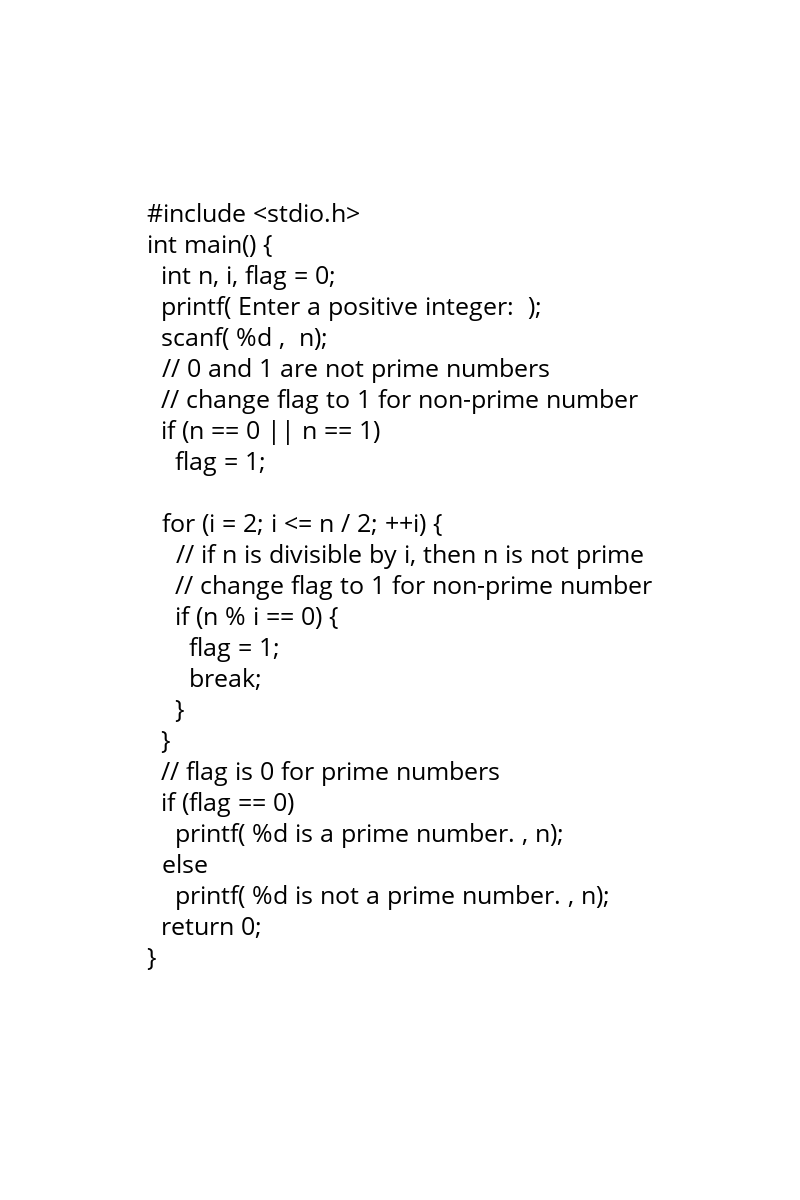

In [281]:
txt = '''#include <stdio.h>
int main() {
  int n, i, flag = 0;
  printf("Enter a positive integer: ");
  scanf("%d", &n);
  // 0 and 1 are not prime numbers
  // change flag to 1 for non-prime number
  if (n == 0 || n == 1)
    flag = 1;

  for (i = 2; i <= n / 2; ++i) {
    // if n is divisible by i, then n is not prime
    // change flag to 1 for non-prime number
    if (n % i == 0) {
      flag = 1;
      break;
    }
  }
  // flag is 0 for prime numbers
  if (flag == 0)
    printf("%d is a prime number.", n);
  else
    printf("%d is not a prime number.", n);
  return 0;
}
'''
txt = filter_text(txt)
_, f_size = draw_multiline_text(txt, size= (600, 400), font='open-sans', font_size=25, show=True)

In [282]:
test(txt, 'open-sans', f_size)

#include <stdio.h>
int main() {
  int n, i, flag = 0;
  printf( Enter a positive integer:  );
  scanf( %d ,  n);
  // 0 and 1 are not prime numbers
  // change flag to 1 for non-prime number
  if (n == 0 || n == 1)
    flag = 1;
  for (i = 2; i <= n / 2; ++i) {
    // if n is divisible-by i, then n is not prime
    // change flag to 1 for non-prime number
    if (n % i == 0) {
      flag = 1;
      break;
    }
  }
  // flag is 0 for prime numbers
  if (flag == 0)
    printf( %d is a prime number. , n);
  else
    printf( %d is not a prime number. , n);
  return 0;
}

0.9965217391304347
0.9973404255319149
0.9965217391304347
0.9973404255319149


In [283]:
test(txt, 'times', f_size)

#include <stdio.h>
  ,,,  ,               ,   ),
int main. . .
,,int,n ,i,(f.a.- = 0.
  printf,,Enter a positive integer:  );
  scanf  %d    n.)
     0,a(d 1 are,not prime numbers
     change f,ag to 1 f .r non-prime number
  if(n == 0 || n == 1)             )
    f.a.- = 1.}
  f-r g = 2; i <= n   2. ++i. .
  -  , ifn is;divisible-by i, then n is not prime
       change f,ag to 1 f .r non-prime number
    if.n % i == 0. .                  )
    ,,f(a.- = 1.      ) {
     break.   ;
        ,   ),;
    :
    }
  :
  } f,ag is 0 f .r prime numbers
  if(f,ag == 0)  )
    printf  %d is a prime number. , n);
  else                    )
   printf  %d is not a prime number. , n);
  return 0.                   )
  ,     ,,,   ;
}

0.6857923497267759
0.8506666666666667
0.6858710562414266
0.8213333333333334


In [284]:
test(txt, 'arial', f_size)

#incIude <stdio.h>
int main() {
  int n, i, fIag = 0;
  printf( Enter a positive integer:  );
  scanf( %d ,  n);
  // 0 and 1 are not prime numbers
  // change fIag to 1 for non-prime number
  if (n == 0 || n == 1)
    fIag = 1;
  for (i = 2; i <= n / 2; ++i) {
    // if n is divisibIe by i, then n is not prime
    // change fIag to 1 for non-prime number
    if (n % i == 0) {
      fIag = 1;
      break:
    }          ;
  }
  // fIag is 0 for prime numbers
  if (fIag == 0)
    printf( %d is a prime number. , n);
  eIse
    printf( %d is not a prime number. , n);
  return 0:
}             ;

0.9365609348914858
0.9628647214854111
0.9365609348914858
0.9628647214854111


In [285]:
test(txt, 'cour', f_size)

#include <stdio.h>
int main() { -
- int n, i, flag = 0;
   rintf( Enter a  ositive inte er:  );
  p -     -       p  - -   -   g
  scanf( %d ,  n);
     0 and 1 are not  rime numbers
  // chan e-fla  to 1pfor non- rime number
  if (n =g 0 ||gn ==-1)       p -
  - fla  = 1;        -
  for-(g = 2; i <= n / 2; ++i) {
    // if n-is-divisible by i, then n is not prime
    // chan e fla  to 1 for non- rime number
    if (n %gi == g) { -         p -
    - fla  =-1;
      break; -
    }
  }/ fla  is 0 for  rime numbers
  if (fla -== 0)   p -
  -    - g
    printf( %d is a prime number. , n);
  else
   -
    printf( %d is not a prime number. , n);
  return 0;
}

0.8051359516616314
0.8596938775510204
0.8066465256797584
0.8596938775510204


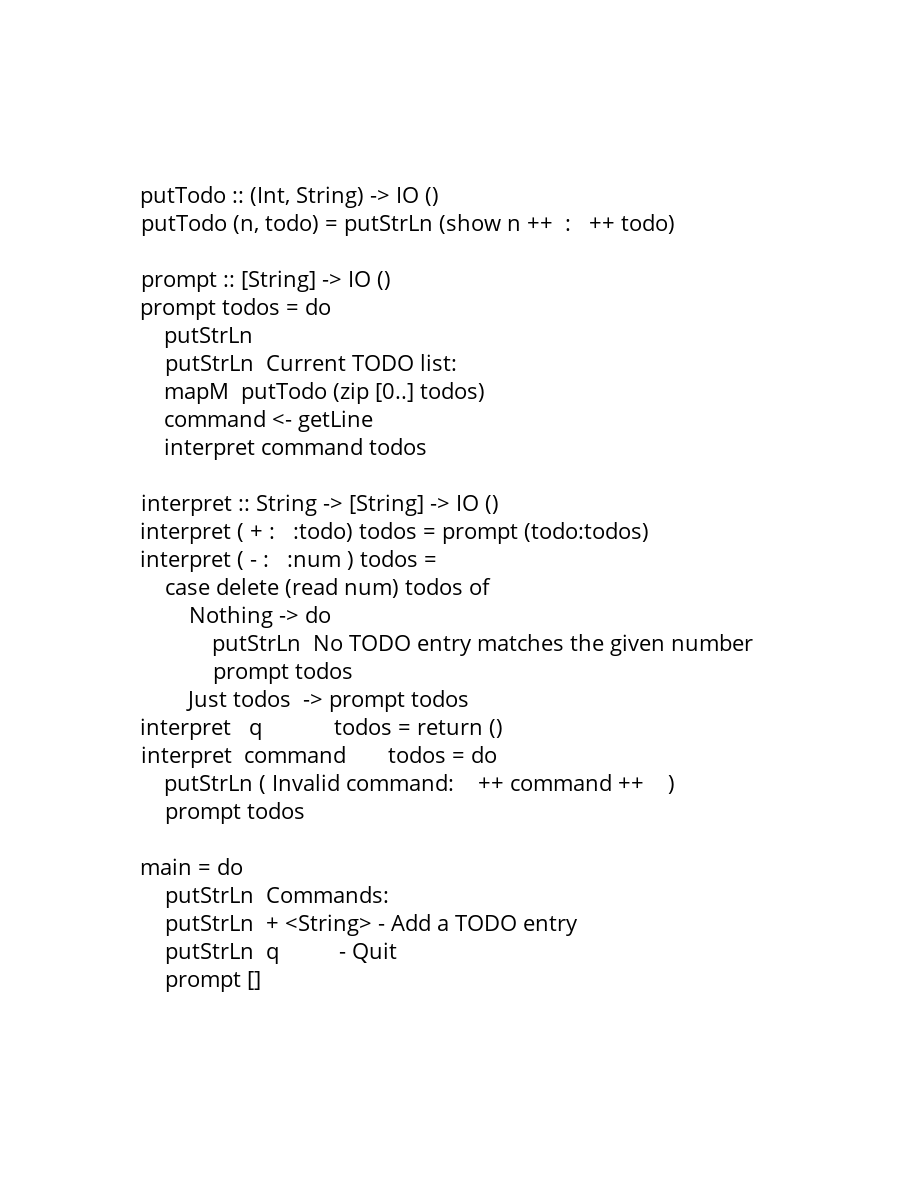

In [293]:
txt = '''putTodo :: (Int, String) -> IO ()
putTodo (n, todo) = putStrLn (show n ++ ": " ++ todo)

prompt :: [String] -> IO ()
prompt todos = do
    putStrLn ""
    putStrLn "Current TODO list:"
    mapM_ putTodo (zip [0..] todos)
    command <- getLine
    interpret command todos

interpret :: String -> [String] -> IO ()
interpret ('+':' ':todo) todos = prompt (todo:todos)
interpret ('-':' ':num ) todos =
    case delete (read num) todos of
        Nothing -> do
            putStrLn "No TODO entry matches the given number"
            prompt todos
        Just todos' -> prompt todos'
interpret  "q"           todos = return ()
interpret  command       todos = do
    putStrLn ("Invalid command: `" ++ command ++ "`")
    prompt todos

main = do
    putStrLn "Commands:"
    putStrLn "+ <String> - Add a TODO entry"
    putStrLn "q          - Quit"
    prompt []
'''
txt = filter_text(txt)
_, f_size = draw_multiline_text(txt, size= (600, 400), font='open-sans', font_size=22, show=True)

In [295]:
test(txt, 'open-sans', f_size)

putTodo :: (Int, String) -> IO ()
putTodo (n, todo) = putStrLn (show n ++  :   ++ todo)
prompt :: [String] -> IO ()
prompt todos = do
    putStrLn
    putStrLn  Current TODO list:
    mapM  putTodo (zip [0..] todos)
    command <- getLine
    interpret command todos
interpret :: String -> [String] -> IO ()
interpret ( + :   :todo) todos = prompt (todo:todos)
interpret ( - :   :num ) todos =
    case delete (read num) todos of
        Nothing -> do
            putStrLn  No TODO entry matches the given number
            prompt todos
       Just todos  -> prompt todos
interpret   q            todos = return ()
interpret  command       todos = do
    putStrLn ( Invalid command:    ++ command ++    )
    prompt todos
main = do
    putStrLn  Commands:
    putStrLn  + <String> - Add a TODO entry
    putStrLn  q          - Quit
    prompt []

0.9848837209302326
1.0
0.9848837209302326
1.0


In [296]:
test(txt, 'arial', f_size)

putTodo :: (Int, String) -> IO ()
putTodo (n, todo) = putStrLn (show n ++  :   ++ todo)
prompt :: [String] -> IO ()
prompt todos = do
    putStrLn
    putStrLn  Current TODO list:
    mapM  putTodo (zip [0..] todos)
    command <- getLine
    interpret command todos
interpret :: String -> [String] -> IO ()
interpret ( + :   :todo) todos = prompt (todo:todos)
interpret ( - :   :num ) todos =
    case delete  read num  todos of
        Nothing - ( do          )
            putStrLn  No TODO entry matches the given number
            prompt todos
        Just todos  -> prompt todos
interpret   q            todos = return ()
interpret  command       todos = do
    putStrLn ( Invalid command:    ++ command ++    )
    prompt todos
main = do
    putStrLn  Commands:
    putStrLn  + <String> - Add a TODO entry
    putStrLn  q          - Quit
    prompt []

0.9686046511627907
0.9930313588850174
0.9709302325581395
0.9947735191637631


In [297]:
test(txt, 'times', f_size)

 !,utTodo :: (Int, String) -> IO ()
 !,utTodo (nptodo) = !,utStrLn (show n ++  :   ++ todo)
 !,rom!,t :: [String] ->,IO () +pp p     p                p  p
 !,rom!,t todos =,do  p   p
pp !,utStrLn      p
     !,utStrLn  Current TODO list:
     ma!,Mp!,utTodo (zi!, [0..] todos)
     command <- .,etLine ,   pp  p
     inter!,ret comg,and todos
 inter!,ret :: String -> [String] -> IO ()
 inter!,ret ( + :p :todo) todos = !,rom!,t (todo:todos)
 inter!,ret ( - :   :num ) todos = p pp pp   p  p  p
pp case deletepread num. todos of
   p,p Nothin., (>,dopppp)p  p     p
             !,utStrLnpNo TODO entry matches the given number
             !,rom!,t todosp  p      pp , ppp p    pp   ,p  p pppp  p
         Just todos  -> !,rom!,t todos
 inter!,ret pqp          todos = return ()
 inter!,ret  command   p  todos = do
pp !,utStrLn ( Invalid command: p ++ command ++    )
     !,rom!,t todos ppp   ppp ppp            ppp ppp
 main = do   p
ppp;.utStrLn  Commands:
     !,utStrLn  + <String> - Add a TOD

In [294]:
test(txt, 'cour', f_size)

}utTodo :: (Int, Strin}) -> IO ()
putTodo (n, todo) ]}ugStrLn (show n ++  :   ++ todo)
prom t ::/Strin}  -p IO }-          //  )  //   )
prompt todos ] dg]       ()
p   putStrLn - )
    putStrLn  Current TODO list:
    ma M (utTodo }zi ( 0..  todos
    command <-}etLine [   ]   ) )
    inter ret cgmmand todos
inter retp:: Strin} ->  Strin}  -> IO }
interpret })+ :   gtodo[ todog]=}rom t)}todo:todos
interpret ( - ]   ]num ) todos = p   p  (  ))  ) )
    case delete }read num  todos of
        Nothin} (> do    )   )   /
        )  }ugStrLn  No TODO entr  matches the}iven number
            prom t-todos ((      y             g       /
        Justptodos  ->}rom t todos
interpret   q  )      p todos ] return ()
inter ret  command       todos = do
    }ptStrLn } ]nvalid command:- )++ command ++
    prom t-todos     )       )    //       )//    )
mainp= do    )
    }utStrLn  Commands:
    putStrLn  + <Strin}> - Add a TODO entr
    putStrLn  q  }    g  - Quit  ((      y
    }     -   }       

### Testy obrazów źle zorientowanych

In [319]:
characters = string.ascii_uppercase + string.ascii_lowercase + string.digits + ".,?!"

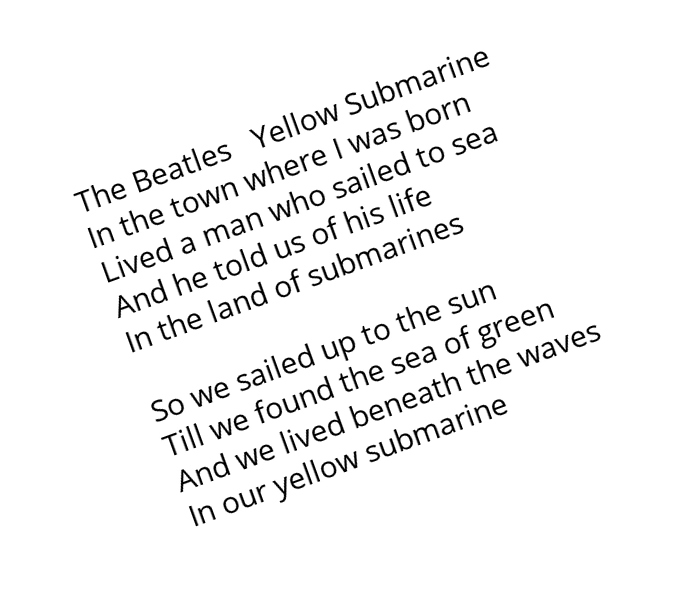

In [323]:
txt = '''The Beatles, Yellow Submarine
In the town where I was born
Lived a man who sailed to sea
And he told us of his life
In the land of submarines

So we sailed up to the sun
Till we found the sea of green
And we lived beneath the waves
In our yellow submarine
'''
txt = filter_text(txt)
out, f_size = draw_multiline_text(txt, size= (500, 300), font='open-sans', font_size=30)
display(rotate_image(out, 20))

In [326]:
test(txt, 'open-sans', f_size, angle=20, eps=0.2, rotate=True)

Tne Beat!es   Ye!!ow Submarine
!n tne town wneile ! was born
Lived a man wno sai!ed to sea
Andq.e to!d . slof nisi!iq.
!n q.e !ancq .f subma.!ines
So we saiq.q up to tne sun
Ti!! we founq tne sea of green
And we !ived beneatn tne waves
!n q..r ye!!oq submaiine

0.8007662835249042
0.77
0.9066147859922179
0.8955223880597015


In [327]:
test(txt, 'times', f_size, angle=20, eps=0.2, rotate=True)

lhe Beat.es   Yel.ow Subma.ine
n  tne town whe.e l was bo.n   ,
l ived a man who saned  o  ea
And he to!d us ol his1le    ,
ln tne l .nd ol subma.ines
So we saued up to the sun
l u. we lound the sea ol g.een
And we uved beneatn  he waves
n  our vel.o.. subma.ine,
!         y                       ,

0.69
0.785
0.6983050847457627
0.81
